#Introduction

The goal of this project was to build a simple system that could measure a person's heart rate and blood oxygen levels using the MAX30102 sensor. The idea was to calculate the user's BPM (beats per minute) and, based on their age and sex, place them into a fitness category. This could be useful in fitness monitoring, personal health tracking, or a stepping stome towards a more advanced portable device. The project was divided into two parts. In the first part, I used Arduino to collect and analyze data directly from the sensor. While the system worked, I noticed that the BPM values were often unstable or innacurate.That led me to the second part of the project, where I focused on improving the accuracy of the readings and creating a visual interpretation of the results, using Python.

Overall, this project highlights how an affordable health sensors, like the MAX30102 can be very useful tools, especially when paired with processing to improve the accuracy and clarity of the data.



#Project Description

## Objective

The main goal of this project was to measure heart rate using the MAX30105 sensor and determine the user's cardiovascular fitness level based on their age and sex. This project also aimed to improve the accuracy of heart rate detection by developping a real-time visualization that analyzes and filters the sensor data more effectively than Arduino processing


## Inspiration

This project was inspired by my interest in biomedical technology and my future career in medicine. With wearable devices becoming more and more common in both the clinical and commercial settings, I wanted to explore how simple devices like the MAX30102 sensor could be used to measure vital signs. This project was also influenced by online tutorials and open-source initiatives that showed real-time heart rate monitoring using Arduino. These resources showed me that my project was possible to achieve. A major source of inspiration was SparkFun's tutorials and documentation.

## Design and planning

The project began with a brainstorming session focused on defining the overall goals. I wanted to create a system that could represent a person's vital signs, specifically heart rate, through either visual or auditory feedback. An early idea was to make this device portable, though that part was later set aside to prioritize improving the quality of data interpretation.

Once the scope of the project was clearer, I began identifying the necessary hardware components. There was of course the MAX30101 sensor, which was then replaced with the MAX30102. I also considered potential output methods (LEDs, sound, OLED screen). However, one of the early challenges was that the initial sensor we used failed to function properly. After several troubleshooting attempts, we determined that it was defective and had to replace it with a new MAX30102 unit.

 With the functioning sensor in place, I planned the project in four main steps:

1. Get the sensor working: Establish basic data collection to verify that the sensor is working and able to read IR and red light data

2. Collect and evaluate data: Log readings to assess signal quality and verify if they were consistent enough for heart rate analysis.

3. Build an interactive fitness tool: Calculate BPM and compare it to user demographic data (age and sex) to provide feaedback

4. Create a real-time visualization: Use either the Arduino IDE or Python to build a display of the heartbeat, mimicking an EKG machine, but with light data instead of electrical impulse.

Although this structure provided a solid foundation, it evolved over the course of the project. As I encountered hardware problems and limitations in accuracy, I shifted more focus towards optimizing the signal processing.


# Implementation

## Hardware setup


### 1. MAX30102 Sensor
- **Overview:** Measures heart rate and oxygen saturation using infrared and red LEDs. Communicates via I2C and works with 1.8V–3.3V voltage.
<p align="justify">
- **Description:** This sensor works by being in contact with skin, preferably a thin part of the body, such as a fingertip or an earlobe. Let's see how it works in more detail. The amount of Hemoglobing, an oxygen carrier protein, in our blood varies between heart beats. This protein also absorbs infrared light.  Hence, by sending infrared light into the skin and measuring the amount that is reflected, using a photoreceptor, the sensor can measure the changes in Hemoglobin levels and see a pattern that matches our heart beat. This method of heart-rate measurement is called Photoplethysmography (PPG). This sensor can also measure oxygen saturation by pulse oximetry, a method that used two lights: infrared (880nm) and red light (660nm). This is possible because oxygenated hemoglobin absorbs more infrared light while deoxygenated hemoglobin absorbs more red light. Similar to the heart rate measurement, the sensor sends both wavelengths of light into the skin and compares the amount of red and infrared light absorbed. This allows it to calculate the percentage of hemoglogin that carries oxygen.
</p>

### 2. Bidirectional Logic Level Converter
- **Description:** Safely converts logic signals (electrical signals) between 5V (Arduino) and 3.3V (MAX30102) to prevent damage. *See the last section for more detail*

### 3. Microcontroller (Arduino Uno)
- **Description:** Runs the code that controls the sensor, reads data via I2C, and processes or sends it to the computer.

### 6. Breadboard and Jumper Wires
- **Description:** Used for building the circuit.

### 7. Computer
- **Description:** Used to write, upload, and monitor code via the Arduino IDE.

### Additional components for data storage
#### 8. MicroSD Card Module
- **Description:** Enables local storage of data to a microSD card.

#### 9. microSD Card
- **Description:** Removable memory card where the heart rate data is logged.

### Explanations for the logic level converter
<p align="justify">
When connecting the MAX30102 sensor to the Arduino Uno, a logic level converter is needed because they don't operate with the same voltage. The Arduino Uno uses 5V logic, meaning that its pins send signals at 5V. In contrast, the MAX30102 operates on a 3.3V logic, which cannot tolerate 5V signals. While the Arduino does have a 3.3V power output, this only provides power, it does not change the voltage level of the data signals, which remain at 5V. This is an issue, because we are working with an $I^2C$ communication protocol, which is how the Arduino and the sensor exchange data. $I^2C$ uses two lines: SDA (data) and SCL(clock). If the Arduino's 5V signals are being sent directly to the sensor's 3.3V SDA and SCL pins, it can damage the sensor. A bidirectional logic level converter solves this by acting as an intermediary, translating the 5V signals to 3.3V and vice-versa. It is bidirectional because the $I^2C$ protocal works both ways, both the Arduino and the sensor must be able to send and receive data on the same lines.
</p>

The following image shows a logic level converter like the one used in this project. One side of the converter is for high-voltage, this is the side directy connected to the Arduino. The other side, the low-voltage, is connected to the sensor.


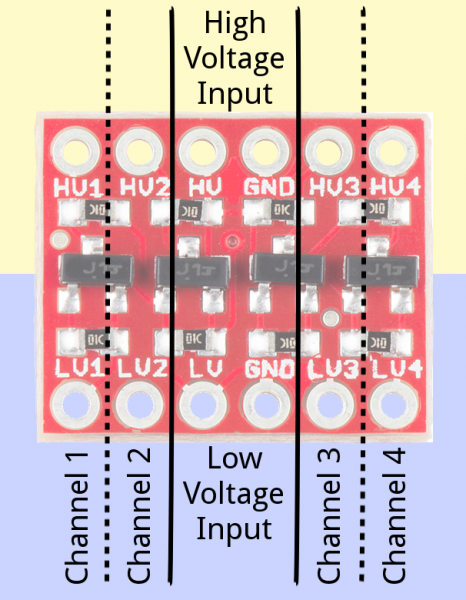

## Schematic

| Arduino Pin | Logic Converter | MAX30102    |Description|
|-------------|--------------   |-------------|-----------|
| 3.3V        | LV              | VIN         |Powers MAX30102 via the low-voltage side (3.3V)|
| 5V          | HV              | ---         |Supplies 5V to high-voltage side of converter. Allows converter to accept the 5V from Arduino|
| GND         | GND(both sides) | GND         |Common ground connection. Reference point, all the devices must share ground|
| A4          | HV1             | ---         |Links Arduino's $I^2C$ data line to converter. Transmits data from Arduino to sensor |
| A5          | HV2             | ---         |Links Arduino's $I^2C$ clock line to converter. Synchronizes the timing of data transfer between Arduino and sensor|
| 2           | ---             | INT         |Optional interrup signal. Alerts Arduino when a new sample of data is ready|
| ---         | LV2             | SCL         |Links converter's $I^2C$ data line to sensor. MAX30102 receives data requests via this line |
| ---         | LV1             | SDA         |Links converter's $I^2C$ clock line to sensor. Guides the sensor in the timing of data transfer|



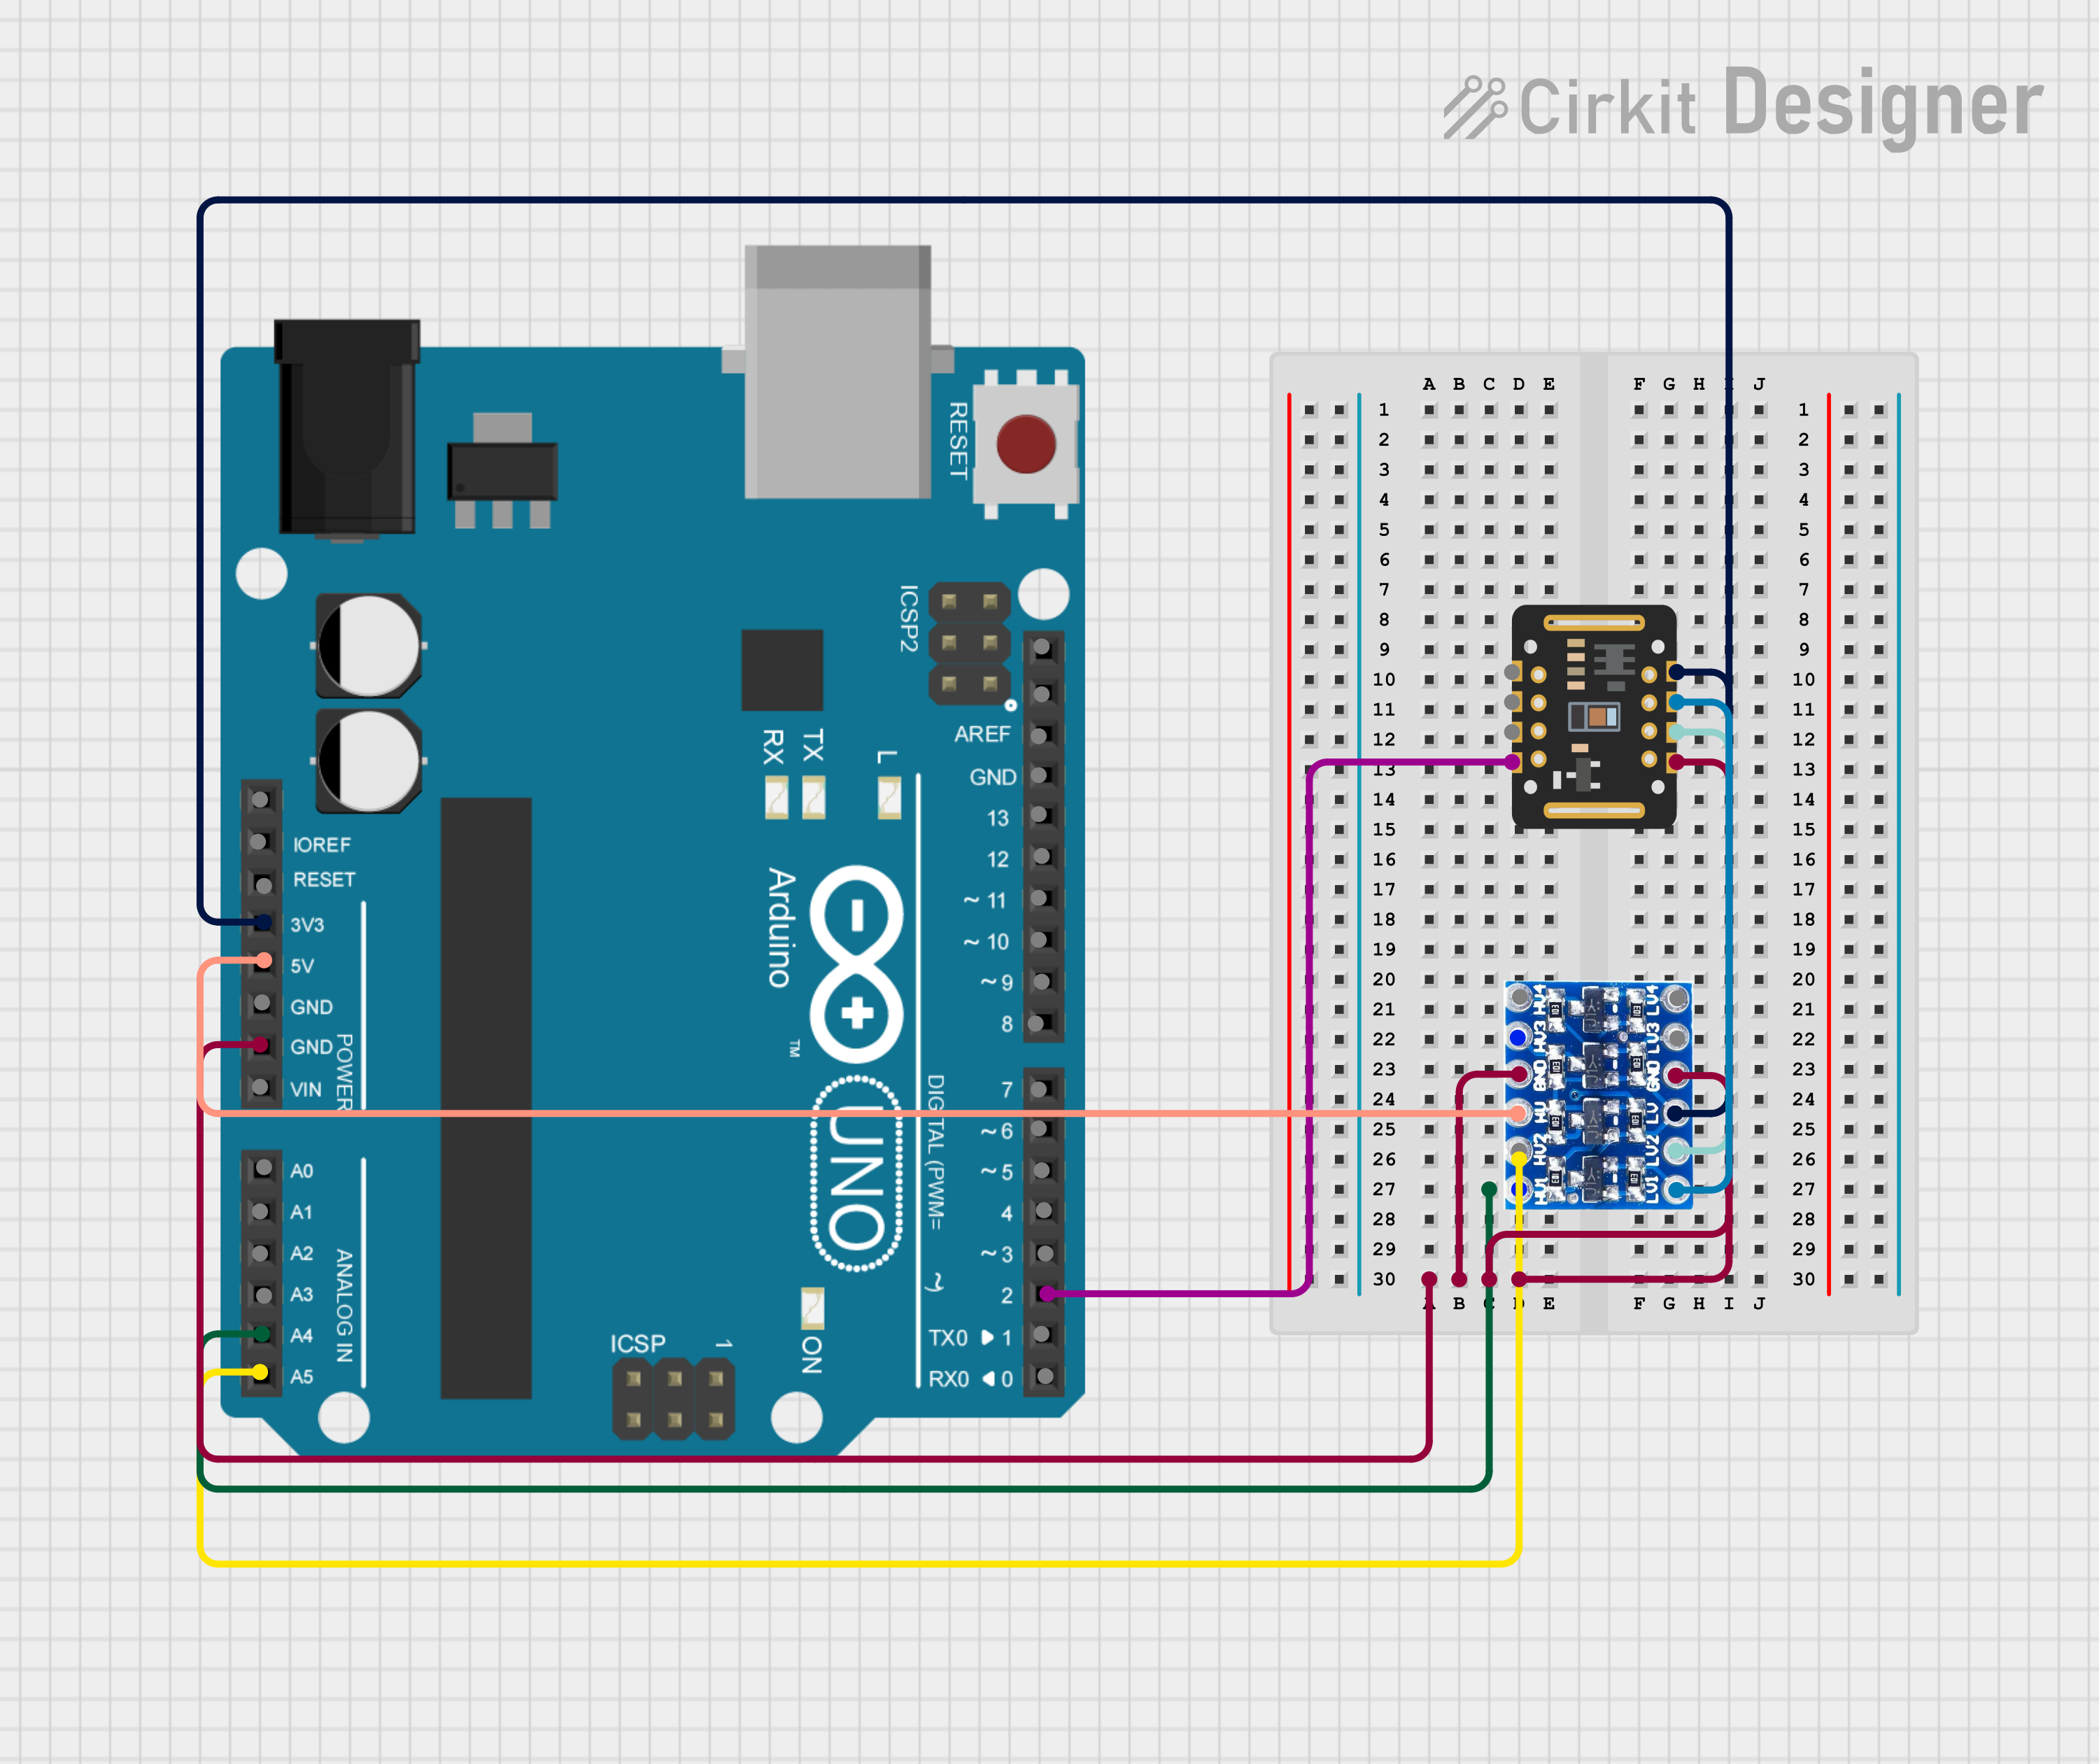

## Software development

### BPM calculation

Since the MAX30102 sensor only returns raw light intensity data, calculating the heart rate (in BPM) from the IR readings required some thinking. The foundation of this strategy is the assumption that each peak in the IR signal represents a hearbeat. Thus, by identifying peaks and measuring the time between them, we can compute an accurate heart rate without needing external libraries for BPM calculation. The equation used is simple:$$BPM=60/(\text{interval between peaks})$$

But to apply this reliably, especially in real time, several important factors were taken into account:

#### 1. Detecting peaks in the signal
  The first step is to identify the peaks, local maxima in the IR signal that correspond to individual heartbeats.

  Rather than implementing a manual peak-finding algorithm, which after some trials, did not yield good results, I used the function find_peaks() from the spicy.signal library, which is specifically designed for that purpose
  ```python
  from scipy.signal import find_peaks
  ```
  This function analyzes a sequence of data points and returns the indices of data points that qualify as peaks. Two parameters act as particularly important criteria:
   - Prominence:
        - Defines how much higher a peak must be relative to the neighbouring values to be considered valid. This helps ignore small fluctuations due to noise.


  - Distance:
      - Sets the minimum number of samples that must separate two peaks. This prevents the algorithm from detecting more than one peak per actual heartbeat

```python
peaks, _ = find_peaks(ir_signal, prominence=100, distance=10)
```

Hence this line returns a list of index positions (peaks) where the signal has a maxima that meets the prominence and distance criteria. The selection of prominence and distance values was important. If the values were too low, the algorithm detected false peaks. If too high, it missed real hearbeats. These parameters were adjusted through testing.

#### 2. Measuring time between peaks
  Once the peaks were identified, the program determined when each one occured. Because the IR signals were received with their corresponding timestamps, each index in the signal array corresponded to a time
  ```python
  peak_times = [timestamps[p] for p in peaks]
  ```
  From there, I calculated the time intervals between successive peaks:
  ```python
  intervals = np.diff(peak_times)
  ```
  To ensure logical results, I filtered out any intervals that were zero or negative
  ```python
  valid_intervals = intervals[intervals > 0]
  ```
#### 3. Ensuring sufficient data.
  Before calculating the BPM, the code checks that:
  - There are at least 5 peaks to base the average on
  - A reasonable amount of time has passed
  ```python
  if len(peaks) >= 5 and np.ptp(timestamps) > 2:
  ```
  The start of the data collection often gives a noisy and unstable signal, especially since the user is still adjusting. This prevents the production of innacurate BPM values too early in the reading.

#### 4.Calculating BPM from time intervals.

  Once sufficient data was collected, the software calculated the average interval and then the average BPM:
  ```python
  mean_interval = np.mean(valid_intervals)
  bpm = 60.0 / mean_interval
```
This value was then validated to fall within a plausible range:
```python
if 30 < bpm < 200:
    # Display BPM
else:
    # Discard the result
```

#### 5.Why this approach was chosen

Initially, I attempted to use the Sparkfun MAX3010x Arduino Library, which includes a built in function for BPM calculation. However, this approach yielded unrealistic results for my specific setup. The values obtained were often over 100 bpm, even at rest. Since I needed  more transparency over how the BPM was being calculated, in order to fix the issue, it became clear that I needed to implement my own solution.

My first attempt involved writing a manual peak detection function. The idea was to iterate over the signal values and identify local maxima by checking whether each value was greater than its neighbors. However, this approach produced false positives (detecting false heartbeats) and false negatives (missing real peaks).

After some more testing, I decided to use a more robust method: the find_peaks() function.

### Complete code for BPM

While the BPM calculation is an important part of the code, it is only one part of it. For the BPM estimation to work in real time, the program must:
- Continuously read data from the MAX30102 sensor via serial connection
- Store and updated recent data
- Display the signal and the detect peaks.
- Update BPM calculation without interruptions.

This section explains the rest of the code that supports these tasks.

#### 1.Serial Communication setup
 The IR values generated by the sensor are sent from an Arduino board to the computer over a USB serial connection. To read these values in Python, I used the serial library (pyserial).
 ```python
 import serial
 ```
 This library allows Python to open a communication channel with the Arduino using the correct COM port and baud rate:
 ```python
 PORT = 'COM6'           
 BAUD_RATE = 115200

 try:
    ser = serial.Serial(PORT, BAUD_RATE, timeout=1)
    time.sleep(2)  # Gives the Arduino time to reset
 except Exception as e:
    print(f"Error: Cannot open {PORT}. {e}")
    exit()
 ```
  I implemented a try-except block to handle situations where the serial port is not available, to ensure that the software doesn't crash without explanation. The 2-second pause with time.sleep(2) is important because most Arduino boards reset when a serial connection is opened. This gives the board time to reinitialize and begin sending data.

#### 2.Signal buffering
  To calculate the BPM and plot the signal, a fixed-length buffer is used to store the most recent IR values and their corresponding times. This approach was inspired by the Sparkfun repository for the MAX30102 sensor. It mimicks a sliding window over the data, which keeps only the most recent samples.
  ```python
  LIST_SIZE = 300
  data = [0] * LIST_SIZE
  timestamps = [time.time()] * LIST_SIZE
  ```
  These buffers ensure that:
   - The graph always has a consistent number of points to display
   - The peak detection only considers the most recent values
   - Memory usage stays constant no matter how long the program runs

  As new values arrive from the Arduino, the oldest values are removed:
   ```python
   data.append(ir)
   timestamps.append(now)
   if len(data) > LIST_SIZE:
      data.pop(0)
      timestamps.pop(0)
  ```
  This prevents the buffers from growing indefinitely.

#### 3.Real-time plotting
  To display the IR signal in real time, similar to the Arduino serial plotter, I used the *FuncAnimation* from *matplotlib.animation*. This creates a live-updating plot that updates at regular intervals (every 50ms, matching the sensor's sample rate):
  ```python
  import matplotlib.pyplot as plt
  import matplotlib.animation as animation
  ```
  The plot is initialized with basic styling and axis:
  ```python
  fig, ax = plt.subplots(figsize=(10, 5))
  line, = ax.plot([], [], lw=2, color='deepskyblue', label='IR Signal')
  peaks_line, = ax.plot([], [], 'ro', label='Detected Peaks')

  ax.set_title("Real-Time IR Signal (Heartbeat)", fontsize=14, weight='bold')
  ax.set_xlabel("Sample Index")
  ax.set_ylabel("IR Value")
  ax.set_xlim(0, LIST_SIZE)
  ax.legend(loc="upper right")
  ax.grid(True, linestyle='--')
  ```
  These elements are reused and updated in every animation frame by the animate() function.

#### 4. The animate() function
  This function runs continuously and is responsible for:
  - Reading new data from the serial port
  - Updating the signal and timestamp buffers
  - Detecting peaks
  -Calculating BPM
  -Updating the graph in real time
  ```python
  def animate(frame, data, timestamps, ser):
      while ser.in_waiting:
          try:
              raw = ser.readline().decode('utf-8').strip()
              ir = int(raw)
              now = time.time()
              data.append(ir)
              timestamps.append(now)
              if len(data) > LIST_SIZE:
                  data.pop(0)
                  timestamps.pop(0)
          except:
              continue
  ```
  Using ser.in_waiting ensure that the program doesn't block while waiting for information over the serial port. The data is then decoded, converter to interger, and timestamped.

#### 5.Real-time plotting

  After reading and updating the buffer, the function replots the signal
  ```python
  x = np.arange(LIST_SIZE)
  y = np.array(data)
  line.set_data(x, y)
  ```
  Peaks are then detected using the method described earlier, and they are plotted in red:
  ```python
  peaks, _ = find_peaks(y, prominence=PROMINENCE, distance=PEAK_DISTANCE)
  peaks_line.set_data(peaks, y[peaks])
  ```
  This helps confirm visually whether the algorithm is correctly detecting peaks.

#### 6. Y-Axis Scaling
 Since the IR signal amplitude can vary significantly between users, the vertical axis must auto-adjust to remain centered and zoomed.
 ```python
 y_center = np.mean(y)
 y_range = (np.max(y) - np.min(y)) / 2 + 500
 ax.set_ylim(y_center - y_range, y_center + y_range)
 ```
 This keeps the signal centered around the average and ensures it doesn't appear too flat or go off-screen. The addition of +500 provides a small zone to keep the plot readable.

#### 7.Running the animation

  Finally, the animation is started using *Funcanimation*:
  ```python
  ani = animation.FuncAnimation(
    fig,
    animate,
    fargs=(data, timestamps, ser),
    interval=50  # Update every 50 ms
  )
  plt.tight_layout()
  plt.show()
  ```
  This function calls animate() every 50 ms.








### Oxygen saturation calculation

The following section explains how my code calculates the SpO₂ value, based on infrared (IR) and red light absorption data from the sensor.

Hemoglobin, the molecule in red blood cells that carries oxygen, absorbs red and infrared light differently depending on whether it is oxygenated or deoxygenated:
 - Oxygenated hemoglobin absorbs more infrared and less red light
 -Deoxygenated hemoglobin absorbs more red and less infrared light

By measuring how the intensities of red and IR light fluctuate over time, we can estimate the relative concentration of oxygenated hemoglobin. This fluctuation is caused by pulsatile arterial blood flow, which changes slightly with each heartbeat. However, a significant portion of the light absorbtion remains constant, due to tissues like muscle and skin. This constant value is called the DC signal, representing the average light absorption. The fluctuation component, which rises and falls with the heartbeat is called the AC signal

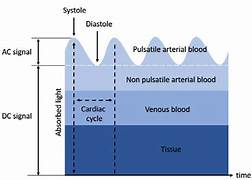

Using the AC and DC components of both red and IR light, we can compute a value R, the "ratio of ratios", which is directly correlated with oxygen saturation:
$$
R = \frac{ \left( \frac{\text{AC}_{\text{red}}}{\text{DC}_{\text{red}}} \right) }{ \left( \frac{\text{AC}_{\text{IR}}}{\text{DC}_{\text{IR}}} \right) }
$$

Based on this, SpO₂ is estimated using the formula:
$$
\text{SpO}_2 = 110 - 25 \times R
$$

##### How AC and DC components are calculated

  The DC component is calculated as the average signal over time. To isolate the AC component, we substract the DC component from each individual sample:
  $$
\text{AC}_{\text{signal}} = v_i - V_{\text{DC}}
$$

  Where:
  - $v_i$ is the value of the signal at the $i^{\text{th}}$ sample
  - $V_{DC}$ is the average (DC) value of the signal
  
  However, since the AC signal fluctuates above and below the average, we summarize its magnitude using the **Root mean square (RMS)**.RMS reflects how much the signal deviates from its mean:
$$
\text{RMS}_{\text{AC}} = \sqrt{ \frac{1}{N} \sum_{i=1}^{N} (v_i - V_{\text{DC}})^2 }
$$
  Where:
  - $N$ is the number of samples
  - $V_i$ is each sample's value
  - $V_{DC}$ is the average (DC) value of the signal

The following section outlines the implementation of these concepts in the code:

  In python, the raw IR and red signal values are stored in two arrays: *ir_vals* and *red_vals*, each containing a fixed number of values, similar to the fixed-length buffers of the BPM code. The function *calculate_spo2()* computes SpO₂ as follows:

  ```python
  def calculate_spo2(ir_vals, red_vals):
      ir = np.array(ir_vals)
      red = np.array(red_vals)
  ```

  **Step 1: Calculate the DC component**
  The DC component is the mean of each signal:
  ```python
  mean_ir = np.mean(ir)
  mean_red = np.mean(red)
  ```
  **Step 2: Finger detection**
  If no finger is present on the sensor, the IR signal will be very low. A treshold is used to skip the calculation:
  ```python
  if mean_ir < FINGER_THRESHOLD:
      return None
  ```
  **Step 3: Calculate the AC component**
  The AC component is computed using the equations presented above
  ```python
  ac_ir = np.sqrt(np.mean((ir - mean_ir) ** 2))
  ac_red = np.sqrt(np.mean((red - mean_red) ** 2))
  ```
  **Step 4 : Compute the R ration and SpO₂**
  Using the AC/DC ratio formula:
  ```python
  R = (ac_red / mean_red) / (ac_ir / mean_ir)
  spo2 = 110 - 25 * R
  ```

  **Step 5: Bound the results**
  To ensure the value stays within biological limites (0-100%)
  ```python
  return max(min(spo2, 100), 0)
  ```

### Complete code for oxygen saturation

The overall structure of the SpO₂ calculation is very similar to the BPM program described earlier. It uses the same logic for serial communication, buffering and dynamic plotting. However, there are two key differences that distinguish this particular program.

- Input format:
    
    Instead of receiving a single IR signal, this program reads two values per line from the Arduino. These are separated and stored in separate buffers:
    ```python
    raw = ser.readline().decode('utf-8').strip()
    parts = raw.split(",")
    if len(parts) != 2:
          continue
    ir = int(parts[0])
    red = int(parts[1])

    ir_buffer.append(ir)
    red_buffer.append(red)
    ```
- Visual Output:
  
  Unlike the waveform used for BPM, the oxygen saturation is displayed using a horizontal bar graph that:
     - Fills proportionally to the oxygen percentage
     - Changes color depending on the value: green (normal), yellow (caution), red (critical)
     - Is labeled with the current oxygen value

  ```python
  # Color based on value
    if spo2 > 95:
        bar.set_color("mediumseagreen")
    elif spo2 > 90:
        bar.set_color("gold")
    else:
        bar.set_color("red")

    label.set_text(f"SpO₂: {spo2:.1f}%")
    return bar, label
  ```


# Results

### Method of Data collection

To assess heart rate (BPM) and oxygen saturation (SpO₂), three trials were conducted using a MAX30105 pulse oximeter sensor. Data was collected using three different methods:

  1. SparkFun Example Code
      
      This pre-written Arduino library was used to collect heart rate and SpO₂ values via the serial monitor. It uses built-in peak detection.

  2. My own Arduino Code
  
  This algorithm manually detected peaks in the IR signal. Oxygen saturation was calculated using the AC/DC ratio method.

  3. Python based code

  A Python script read serial IR values in real time, used a built-in peak detection function, and plotted the results on a graph. BPM was calculated based on peak intervals while the oxygen saturation was calculated using the same algorithm as the second method.


Each method had approximately 15 trials and each trial lasted around 30 seconds. Measurements were taken while the subject (me and my family members) was at rest. Graphs were used to visualize the IR signal and verify the accuracy of peak detection.

### Data summary

**Heart Rate measurements**

- Trial 1: Sparkfun code

  The heart rate values fluctuated significantly and often displayed unrealistic readings, exceeding 150-200 BPM.

- Trial 2: Arduino Code

  Average BPM values ranged from 70 to 130 BPM.(see **Figure 1**) Different conditions were tested accross the trials, including variations in finger placement (index finger vs thumb) and lighting environment (ambient light vs darkness) To assess whether the lack of consistency of the heart rate was due to these factors, the standard deviation of BPM values was calculated for each trial. The standard deviation remained relatively constant accross all these trials, suggesting that external factors were not the cause. This indicated that the main source of error was rather related to the accuracy of the peak detection. Hence, after plotting the signal and highlighting the peaks detected, even if the average BPM values were realistic,
  some peaks were missed.

- Trial 3: Python code

  The Python code offered the most stable BPM readings ( around 80 BPM). By visualizing the IR signal and its peaks (**Figure 2**), it was possible to confirm that most true peaks were detected.



**Figure 1 (My own Arduino code)**




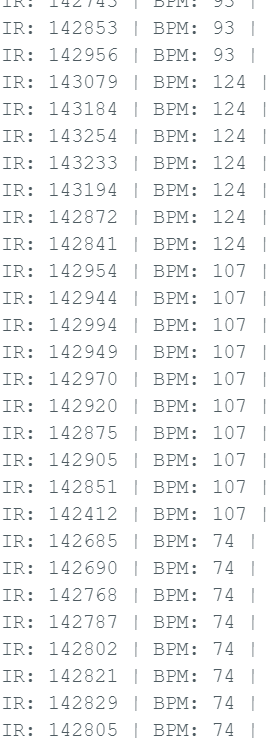

**Figure 2 (BPM with Python)**

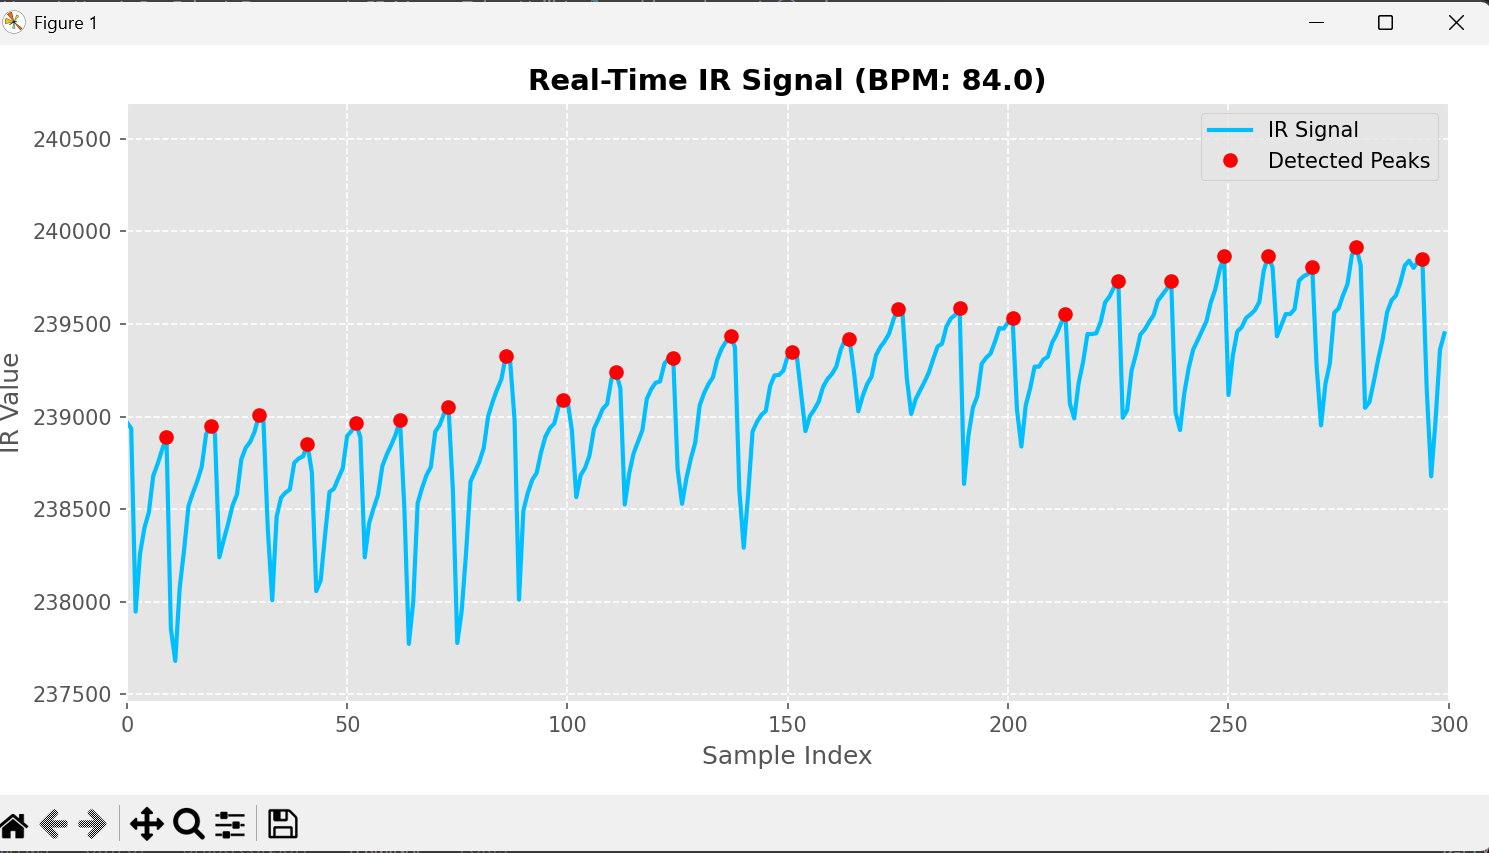

**SpO₂ (Oxygen Saturation) Measurements**

All three methods yielded similar results.

- Trial 1-3:
  SpO₂ values ranged from 90% to 100% accross all methods and were generally consistent. See **Figure 3** for the python final result

**Figure 3 (SpO₂ with Python)**

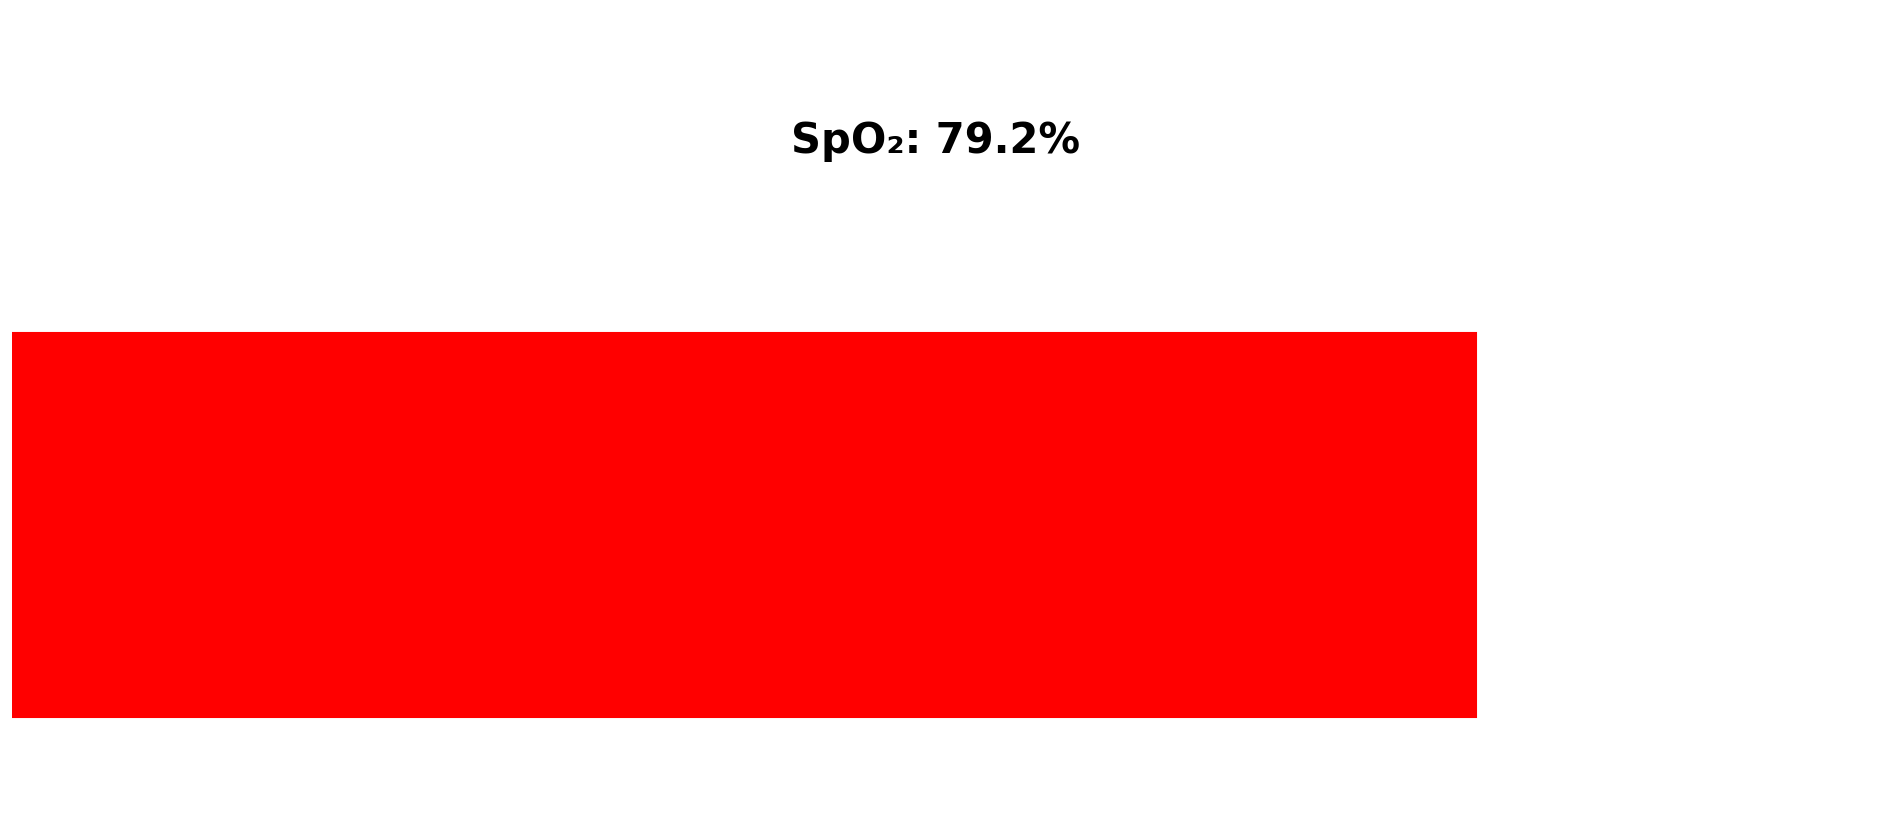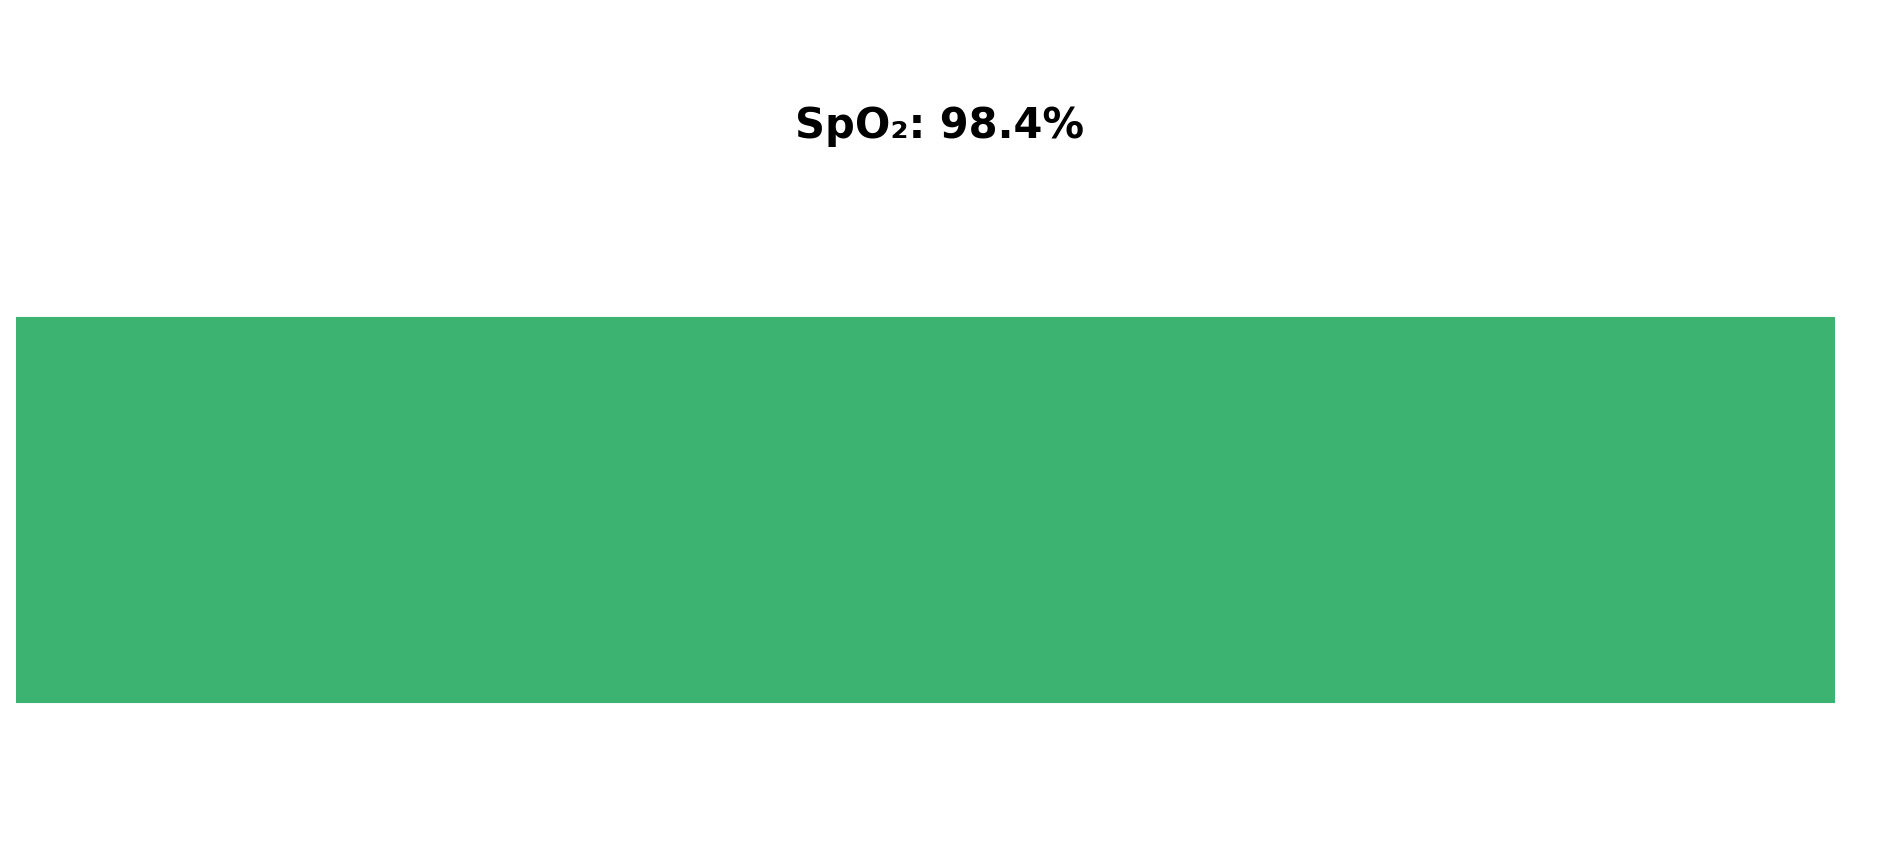

# Analysis

In this section, the focus is on the final implementation of the program using Python. This version offered the most stable and accurate results, especially in terms of heart rate detection. However, while the Python implementation showed improved accuracy, it still missed a few smaller peaks. Visualizing the IR signal over time, with the peaks highlighted, made it easier to identify when peaks were skipped.

For oxygen saturation, results across all three methods were consistent and remained within a normal range (90%-100%). This confirms that the AC/DC ratio method used to compute the SpO₂ is robust. The python version reused the same formula, matching results from the original SparkFun code.

Despite these strengths, there are several limitations:

 - No Interactive Fitness categorization:

 The original plan included building an interactive tool that would take the user’s age and sex, then categorize fitness levels based on heart rate (e.g., "Athlete," "Average," "Poor"). This feature was not completed in the final version due to time constraints.

 - Limited flexibility:
  
  The system does not work equally well for all users. Signal quality may vary depending on skin tone, finger size, skin thickness, or how tightly the finger is placed on the sensor. Additionally, small changes on the pressure applied to the sensor lead to drastically different results.

- High BPM:

  This device was developped for educational purposes. While it shows promise, it is not suitable for a clinical or commercial use, because the BPM values were consistently higher than expected.


In summary, the final Python-based product met the main objective of calculating and visualizing heart rate and oxygen saturation in real time. However, the project did not meet the initial objective of serving as an interactive tool. This current product is functional under certain conditions and could serve as a strong foundation for future improvements.



# Discussion and Conclusion

The goal of this project was to develop a real-time tool that measures and visualizes heart rate (BPM) and oxygen saturation using the MAX30102 sensor. I approached this in multiple stages, starting with pre-existing example code and gradually building up to a customized Python program. In the end, the final version successfully met my initial objective: it provided real-time, visually clear, and biologically realistic feedback on heart rate and oxygen levels.
One of the biggest successes was the noticeable improvement in BPM accuracy throughout the trials. At first, I was seeing highly unrealistic readings,often over 200 BPM, but with multiple trials and errors, I eventually obtained consistent, plausible values. Another success was that the oxygen saturation readings remained reliable across all three methods I tested. This confirmed that the AC/DC ratio method I used for SpO₂ calculation is quite robust when signal quality is adequate.

That said, the project came with its fair share of challenges. A major hurdle was a hardware malfunction with my original sensor, which delayed data collection and forced me to adapt quickly. This, combined with tight time constraints, made the process more intense. I also struggled with inconsistent peak detection in the Arduino-based versions, which led to erratic BPM values early on. However, these difficulties turned out to be valuable learning experiences. I picked up new skills like live data visualization in Python and learned to troubleshoot hardware and write more efficient Arduino code.

If I were to continue improving this project, the most important next step would be to move away from Python while preserving the accuracy of the peak detection algorithm. This would allow me to transition the project to a wearable device with onboard processing, making it more portable and practical. I’d also like to develop a simple and user-friendly interface and reintroduce features I originally planned, like age- and sex-based fitness categorization. These improvements would help the project become more accessible for real-world use.


# References

 - ansh2919, "Serial Communication between Python and Arduino", Project Hub, 2020. URL adress: https://projecthub.arduino.cc/ansh2919/serial-communication-between-python-and-arduino-663756

 - Bagha, Sangeeta & Shaw, Laxmi. "A Real Time Analysis of PPG Signal for Measurement of SpO2 and Pulse Rate". International Journal Of Computer application, 2011. URL adress: https://www.researchgate.net/publication/220043686_A_Real_Time_Analysis_of_PPG_Signal_for_Measurement_of_SpO2_and_Pulse_Rate

 - Geeksforgeeks, "Matplotlib.animation.FuncAnimation class in Python", 2025. URL adress: https://www.geeksforgeeks.org/matplotlib-animation-funcanimation-class-in-python/

 - John Hunter *et al.*, "Animations using Matplotlib", Matplotlib, 2025. URL adress: https://matplotlib.org/stable/users/explain/animations/animations.html

 - Renesas Electronics, "Pulse Oximeter Algorithm for SpO2, Heart Rate, and Respiration Rate", Tokyo, 2021. URL adress: https://www.renesas.com/en/document/apn/ob1203-pulse-oximeter-algorithm-spo2-heart-rate-and-respiration-rate

 - Sparkfun, "SparkFun_MAX3010x_Sensor_Library", Github. URL adress: https://github.com/sparkfun/SparkFun_MAX3010x_Sensor_Library,

 - Scipy, "Signal processing", 2025. URL adress: https://docs.scipy.org/doc/scipy/reference/signal.html



# Acknowledgements

I would like to thank Joel Trudeau for his guidance and making this opportunity possible. I'm also grateful to my family for being my willing lab rats during testing.